In [1]:
# read_sql function
import pandas as pd 

#visualisation
from matplotlib import pyplot as plt


# Redshift and .env file
import psycopg2
import os
from dotenv import load_dotenv
load_dotenv()

dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

#warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# check it worked
print(user)

In [4]:
# connect to redshift - by import the definition from the src foldr
connect = connect_to_redshift(dbname, host, port, user, password)

In [6]:
# sql query to get customer data from the online_transaction_cleaned table 

query = """
        select otc.* 
        from bootcamp.online_transactions_cleaned otc
        """

data = pd.read_sql(query, connect)

In [7]:
data.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom
1,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.80,2010-12-01 09:53:00,u18074,United Kingdom
2,536390,22960,JAM MAKING SET WITH JARS,3.75,12,45.00,2010-12-01 10:19:00,u17511,United Kingdom
3,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom
4,536396,82494L,WOODEN FRAME ANTIQUE WHITE,2.55,12,30.60,2010-12-01 10:51:00,u1785,United Kingdom


In [8]:
data.shape

(399841, 9)

In [9]:
data.dtypes

invoice                      object
stock_code                   object
description                  object
price                       float64
quantity                      int64
total_order_value           float64
invoice_date         datetime64[ns]
customer_id                  object
country                      object
dtype: object

In [10]:
data.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


In [11]:
data.isnull().sum()

invoice              0
stock_code           0
description          0
price                0
quantity             0
total_order_value    0
invoice_date         0
customer_id          0
country              0
dtype: int64

In [12]:
#What are the top ten most popular geographical locations?

top_locations = data.groupby('country').customer_id.nunique().sort_values(ascending=False).head(10)
top_locations


country
United Kingdom    3943
Germany             95
France              87
Spain               30
Belgium             25
Switzerland         21
Portugal            19
Italy               14
Finland             12
Austria             11
Name: customer_id, dtype: int64

In [13]:
#Which country spends the most (you can look at price, quantity or order value i.e. price * quantity)?

top_spender = data.groupby('country').total_order_value.sum().sort_values(ascending=False).round(2).head(10)
top_spender

country
United Kingdom    6815375.09
Netherlands        283479.54
EIRE               251557.47
Germany            200619.66
France             181571.54
Australia          136922.50
Switzerland         51859.40
Spain               51746.65
Belgium             36662.96
Japan               35419.79
Name: total_order_value, dtype: float64

In [14]:
data.total_order_value.sum().round()

8283467.0

In [15]:
data.invoice.nunique()

21791

In [16]:
#Visualize the distribution of Invoices per month?

#divide years (2010 and 2011)
#extract year and month

data['year'] = data['invoice_date'].dt.year
data['month'] = data['invoice_date'].dt.month
data.head(1)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom,2010,12


In [17]:
#table 2010
data2010 = data.loc[data['year']==2010]
data2010.head(1)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom,2010,12


In [18]:
#table 2011
data2011 = data.loc[data['year']==2011]
data2011.head(1)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month
6984,540014,84499,BLACK FLOWER CANDLE PLATE,0.85,6,5.1,2011-01-04 11:34:00,u14606,United Kingdom,2011,1


In [19]:
# monthly invoices 2011 (for 2010. we have just December)
monthly_invoices = data2011.groupby('month').invoice.nunique()
monthly_invoices

month
1     1225
2     1181
3     1588
4     1358
5     1808
6     1686
7     1555
8     1506
9     2038
10    2208
11    3034
12     912
Name: invoice, dtype: int64

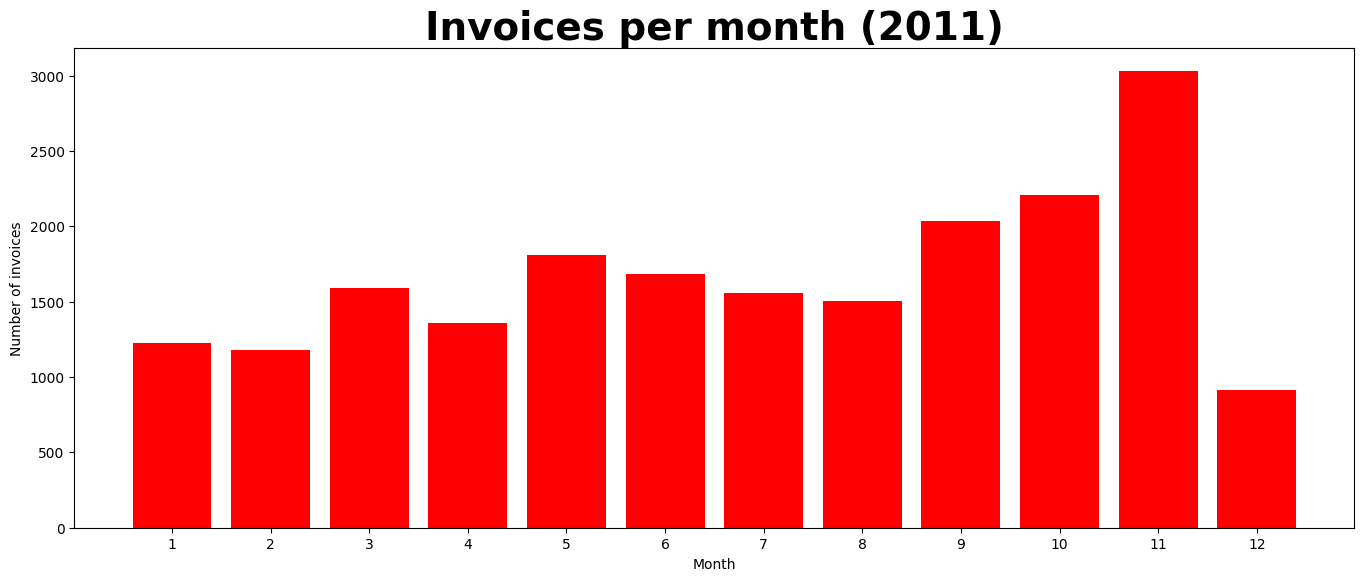

In [20]:
#Visualisation Invoices per month, 2011
fig = plt.figure()
ax = fig.add_axes([0,0,2,1]) 
ax.bar(monthly_invoices.index, monthly_invoices, color='red', width=0.8)
ax.set_title('Invoices per month (2011)', fontsize=28, fontweight='bold')
ax.set_xticks(range(1,13))
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of invoices')
fig.show()

In [21]:
#Which month has the highest number of transactions?

monthly_invoices_2011 = data2011.groupby('month').invoice.nunique().sort_values(ascending=False).head(1)
monthly_invoices_2011

month
11    3034
Name: invoice, dtype: int64

In [22]:
#Which day of the week has the highest number of transactions?

#extract the day

data['dow'] = data['invoice_date'].dt.day_name()
data.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month,dow
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom,2010,12,Wednesday
1,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.80,2010-12-01 09:53:00,u18074,United Kingdom,2010,12,Wednesday
2,536390,22960,JAM MAKING SET WITH JARS,3.75,12,45.00,2010-12-01 10:19:00,u17511,United Kingdom,2010,12,Wednesday
3,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom,2010,12,Wednesday
4,536396,82494L,WOODEN FRAME ANTIQUE WHITE,2.55,12,30.60,2010-12-01 10:51:00,u1785,United Kingdom,2010,12,Wednesday


In [23]:
#calculate invoices per day (2010 and 2011)
invoices_per_day = data.groupby('dow').invoice.nunique().sort_values(ascending=False).head(7)
invoices_per_day

dow
Thursday     4888
Wednesday    4045
Tuesday      3812
Monday       3418
Friday       3294
Sunday       2334
Name: invoice, dtype: int64

In [24]:
#visualise invoices per day for 2011

#interesting to ntice, there are no invoices at Saturdays

data2011['dow'] = data2011['invoice_date'].dt.day_name() #extract the day for 2011

top_day_2011 = data2011.groupby('dow').invoice.nunique().sort_values(ascending=False).head(7)
top_day_2011

dow
Thursday     4430
Wednesday    3678
Tuesday      3570
Monday       3156
Friday       3094
Sunday       2171
Name: invoice, dtype: int64

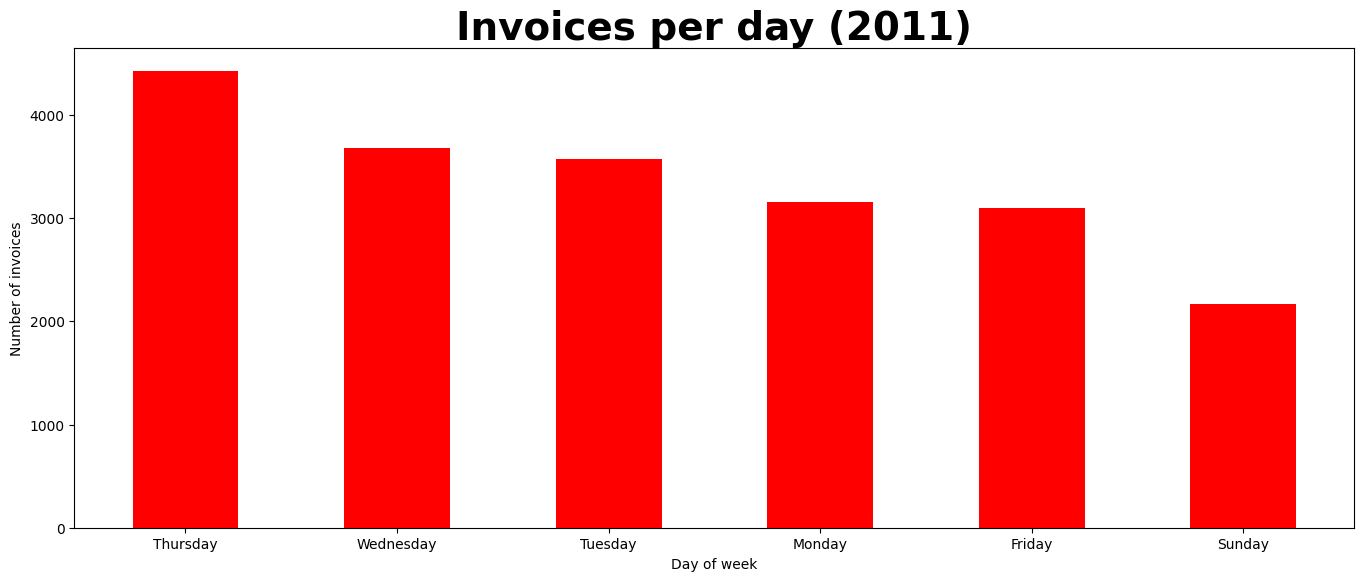

In [25]:
#visualisation invoices per day 

fig = plt.figure()
ax = fig.add_axes([0,0,2,1]) 
ax.bar(top_day_2011.index, top_day_2011, color='red', width=0.5)
ax.set_title('Invoices per day (2011)', fontsize=28, fontweight='bold')
ax.set_xticks(range(0,6))
ax.set_xlabel('Day of week')
ax.set_ylabel('Number of invoices')
fig.show()

In [26]:
data2011.loc[data2011.dow == 'Saturday'].head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month,dow


In [27]:
data2010['dow'] = data2010['invoice_date'].dt.day_name()
data2010.head(1)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month,dow
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom,2010,12,Wednesday


In [28]:
top_day_2010 = data2010.groupby('dow').invoice.nunique().sort_values(ascending=False).head(7)
top_day_2010

dow
Thursday     458
Wednesday    367
Monday       262
Tuesday      242
Friday       200
Sunday       163
Name: invoice, dtype: int64

In [29]:
#Total order value field is the price * quantity. 
#Identify customers that have spent more than the average user.

#who spends more than avg_order_value

#for average we use mean
avg_per_customer = data.groupby('customer_id').total_order_value.sum().mean().round()
avg_per_customer

1899.0

In [30]:
#orders above average 
above_avg = data.groupby('customer_id').total_order_value.sum() > avg_per_customer
above_avg

customer_id
u12346    False
u12347     True
u12348    False
u12349    False
u1235     False
          ...  
u1828     False
u18281    False
u18282    False
u18283     True
u18287    False
Name: total_order_value, Length: 4363, dtype: bool

In [31]:
# Create a Series with total order value per customer
total_order_values = data.groupby('customer_id').total_order_value.sum()
total_order_values

customer_id
u12346       0.00
u12347    4310.00
u12348    1437.24
u12349    1457.55
u1235      294.40
           ...   
u1828      180.60
u18281      80.82
u18282     176.60
u18283    2039.58
u18287    1837.28
Name: total_order_value, Length: 4363, dtype: float64

In [32]:
# Create a boolean mask for customers with order value greater than average
above_avg_customers = total_order_values[total_order_values > avg_per_customer].index
above_avg_customers

Index(['u12347', 'u12356', 'u12357', 'u12359', 'u1236', 'u12362', 'u1237',
       'u12378', 'u1238', 'u12388',
       ...
       'u18231', 'u18241', 'u18242', 'u18245', 'u18251', 'u18257', 'u18259',
       'u1826', 'u18272', 'u18283'],
      dtype='object', name='customer_id', length=901)

In [33]:
# Filter the original data using the mask
above_avg_data = data[data['customer_id'].isin(above_avg_customers)]
above_avg_data

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,year,month,dow
0,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,1,2.95,2010-12-01 09:41:00,u15311,United Kingdom,2010,12,Wednesday
2,536390,22960,JAM MAKING SET WITH JARS,3.75,12,45.00,2010-12-01 10:19:00,u17511,United Kingdom,2010,12,Wednesday
4,536396,82494L,WOODEN FRAME ANTIQUE WHITE,2.55,12,30.60,2010-12-01 10:51:00,u1785,United Kingdom,2010,12,Wednesday
7,536412,22961,JAM MAKING SET PRINTED,1.45,24,34.80,2010-12-01 11:49:00,u1792,United Kingdom,2010,12,Wednesday
16,536370,22900,SET 2 TEA TOWELS I LOVE LONDON,2.95,24,70.80,2010-12-01 08:45:00,u12583,France,2010,12,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
399833,581477,22457,NATURAL SLATE HEART CHALKBOARD,2.95,6,17.70,2011-12-09 08:59:00,u13426,United Kingdom,2011,12,Friday
399834,581486,22561,WOODEN SCHOOL COLOURING SET,1.65,12,19.80,2011-12-09 09:38:00,u17001,United Kingdom,2011,12,Friday
399835,581496,22721,SET OF 3 CAKE TINS SKETCHBOOK,1.95,12,23.40,2011-12-09 10:20:00,u16558,United Kingdom,2011,12,Friday
399836,581495,21523,DOORMAT FANCY FONT HOME SWEET HOME,7.08,10,70.80,2011-12-09 10:20:00,u14051,United Kingdom,2011,12,Friday


In [34]:
#Which customers have purchased the most (look at the frequency of orders)? 

data.groupby('customer_id').invoice.nunique().sort_values(ascending=False).head(15)

customer_id
u14911    243
u12748    217
u17841    169
u14606    125
u13089    118
u15311    118
u12971     88
u13408     75
u14646     74
u16029     66
u14156     65
u13798     63
u18102     60
u16422     60
u13694     57
Name: invoice, dtype: int64

In [35]:
#Can you say anything about customers that purchased recently

recently_invoices_customer = data.groupby('customer_id').invoice_date.max().sort_values(ascending=False).head(20)
recently_invoices_customer

customer_id
u1268    2011-12-09 12:50:00
u13113   2011-12-09 12:49:00
u15804   2011-12-09 12:31:00
u13777   2011-12-09 12:25:00
u17581   2011-12-09 12:21:00
u12748   2011-12-09 12:20:00
u12713   2011-12-09 12:16:00
u12526   2011-12-09 12:09:00
u16705   2011-12-09 12:08:00
u15311   2011-12-09 12:00:00
u12662   2011-12-09 11:59:00
u17315   2011-12-09 11:58:00
u16626   2011-12-09 11:56:00
u18102   2011-12-09 11:50:00
u14446   2011-12-09 11:34:00
u14422   2011-12-09 11:26:00
u17754   2011-12-09 11:20:00
u1591    2011-12-09 10:51:00
u12985   2011-12-09 10:46:00
u15344   2011-12-09 10:45:00
Name: invoice_date, dtype: datetime64[ns]

In [36]:
#Can you say anything about customers that purchased recently

recently_invoices_description = data.groupby('description').invoice_date.max().sort_values(ascending=False).head(20)
recently_invoices_description

description
ALARM CLOCK BAKELIKE PINK             2011-12-09 12:50:00
SPACEBOY LUNCH BOX                    2011-12-09 12:50:00
CHILDRENS CUTLERY CIRCUS PARADE       2011-12-09 12:50:00
CHILDRENS CUTLERY DOLLY GIRL          2011-12-09 12:50:00
CHILDRENS CUTLERY SPACEBOY            2011-12-09 12:50:00
PACK OF 20 SPACEBOY NAPKINS           2011-12-09 12:50:00
PLASTERS IN TIN CIRCUS PARADE         2011-12-09 12:50:00
PLASTERS IN TIN STRONGMAN             2011-12-09 12:50:00
ALARM CLOCK BAKELIKE RED              2011-12-09 12:50:00
CHILDRENS APRON SPACEBOY DESIGN       2011-12-09 12:50:00
CIRCUS PARADE LUNCH BOX               2011-12-09 12:50:00
CHILDREN'S APRON DOLLY GIRL           2011-12-09 12:50:00
ALARM CLOCK BAKELIKE IVORY            2011-12-09 12:50:00
ALARM CLOCK BAKELIKE GREEN            2011-12-09 12:50:00
BAKING SET 9 PIECE RETROSPOT          2011-12-09 12:50:00
RED RETROSPOT ROUND CAKE TINS         2011-12-09 12:49:00
LARGE CAKE STAND  HANGING STRAWBERY   2011-12-09 12:49:00
DO